In [ ]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# visualization purpose
import matplotlib.pyplot as plt

# utils
import pickle
import random

# import our ensemble stacking model here
#from deepstack.ensemble import StackEnsemble

from google.colab import files, drive
drive.mount('/content/gdrive', force_remount=True)

src = list(files.upload().values())[0]
open('model_ensembles.py','wb').write(src)
from model_ensembles import EnsembleStacking
#from params import Params

Mounted at /content/gdrive


Saving model_ensembles.py to model_ensembles (1).py


# Data Preparation



---

Load data Breast Cancer Diagnosis and Breast Cancer Prognosis after cleaned and preprocessed

In [ ]:
from google.colab import drive
breast_cancer_preprocessed  = pickle.load(open('/content/gdrive/My Drive/ITS_S2/KK/preprocessed_breast_cancer_data.pkl', 'rb'))
#breast_cancer_preprocessed

# diagnosis breast cancer dataset
diagnosis_X_train_original = breast_cancer_preprocessed['diagnosis']['original']['X_train']
diagnosis_X_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['X_train']
diagnosis_X_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['X_train']

diagnosis_y_train_original = breast_cancer_preprocessed['diagnosis']['original']['y_train']
diagnosis_y_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['y_train']
diagnosis_y_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['y_train']

diagnosis_X_test_original = breast_cancer_preprocessed['diagnosis']['original']['X_test']
diagnosis_y_test_original = breast_cancer_preprocessed['diagnosis']['original']['y_test']



# prognosis breast cancer dataset
prognosis_X_train_original = breast_cancer_preprocessed['prognosis']['original']['X_train']
prognosis_X_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['X_train']
prognosis_X_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['X_train']

prognosis_y_train_original = breast_cancer_preprocessed['prognosis']['original']['y_train']
prognosis_y_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['y_train']
prognosis_y_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['y_train']

prognosis_X_test_original = breast_cancer_preprocessed['prognosis']['original']['X_test']
prognosis_y_test_original = breast_cancer_preprocessed['prognosis']['original']['y_test']

# Defining Global Variables

In [ ]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for MLP
hidden_layer_sizes=(100,20)
max_iter=100
batch_size=64 
verbose=1
n_iter_no_change=20

# Defining Global Functions

In [ ]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()
    list_of_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            list_of_models.append('majority_vote_from_'+model_name)
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features.columns = list_of_models
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

In [ ]:
def print_model_experiment_results(name_of_scenario, y_test, y_pred):
    print('\t\t' + '='*30)
    print('\t\tHASIl UJI COBA {}'.format(name_of_scenario.upper()))
    print('\t\t' + '='*30)
    print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
    print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
    print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
    print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
    print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
    print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))
    
    print()
    print()
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(14,8))
    disp.plot()
    plt.show()

# Hyperparameter Optimization Techniques Using Grid Search

---

Find the best optimal hyperparameter from each model (SVM, DT, LR and also hyperparameter in ANN) and then build your model using the those best hyperparameter combination.

# **EKSPERIMEN 2**

# **Prognosis breast cancer (Downsampling Dataset)**

## Create Stacking ML Ensemble using 5-fold cross-validation

In [ ]:
ensemble_classifiers_prognosis_downsampling = EnsembleStacking(
    prognosis_X_train_downsampling, 
    prognosis_y_train_downsampling, 
    prognosis_X_test_original, 
    prognosis_y_test_original, 
    kfold).train_ensemble()


In [ ]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results_prognosis_downsampling = list()
for model in ensemble_classifiers_prognosis_downsampling.keys():
    ensemble_classifiers_results_prognosis_downsampling.append(pd.DataFrame(ensemble_classifiers_prognosis_downsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results_prognosis_downsampling = pd.concat(ensemble_classifiers_results_prognosis_downsampling, axis=0)
ensemble_classifiers_results_prognosis_downsampling

,train,training,validation,testing
model-2,SVC(),0.910714,0.571429,0.692308
model-3,SVC(),0.892857,0.5,0.692308
model-1,SVC(),0.892857,0.5,0.641026
model-4,SVC(),0.875,0.5,0.641026
model-5,SVC(),0.892857,0.642857,0.512821
model-2,LogisticRegression(solver='newton-cg'),0.732143,0.571429,0.717949
model-3,LogisticRegression(solver='newton-cg'),0.803571,0.5,0.666667
model-4,LogisticRegression(solver='newton-cg'),0.767857,0.5,0.641026
model-1,LogisticRegression(solver='newton-cg'),0.75,0.571429,0.615385
model-5,LogisticRegression(solver='newton-cg'),0.767857,0.714286,0.564103


## Create New Input Training from stacking ensemble ML

In [ ]:
new_input_training_features_prognosis_downsampling = create_new_input_features(
    ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_train_original,
    prognosis_y_train_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [ ]:
new_input_training_features_prognosis_downsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,1,1,1,1,0
1,1,1,1,1,1
2,1,1,1,1,0
3,1,1,1,1,1
4,0,1,1,0,0


## Feed New Input Features into ANN Model

In [ ]:
# split X and y from new_input_features before feeding to ANN
new_X_train = new_input_training_features_prognosis_downsampling.drop(['ground_truth'],axis=1)
new_y_train = new_input_training_features_prognosis_downsampling['ground_truth']

# feed new X and new y into ANN
ann_model_prognosis_downsampling = MLPClassifier()
ann_model_prognosis_downsampling.fit(new_X_train, new_y_train)
predicted_ann_train_prognosis_downsampling = ann_model_prognosis_downsampling.predict(new_X_train)
predicted_ann_train_prognosis_downsampling = ann_model_prognosis_downsampling.predict(new_X_train)


print()
print()
print("Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (DownSampling) = ", accuracy_score(new_y_train, predicted_ann_train_prognosis_downsampling))



Final Accuracy Score [Mls Ensembles + ANN] on Training Diagnostic Dataset (DownSampling) =  0.8376623376623377


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#SVM

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, precision_score, fbeta_score
param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
               'C': [50, 10, 1.0, 0.1, 0.01]}
svm_estimator = SVC(gamma='scale')
cv = kfold
svm_result_prognosis_downsampling = HalvingGridSearchCV(svm_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_downsampling, prognosis_y_train_downsampling)
y_pred_svm_prognosis_downsampling = svm_result_prognosis_downsampling.predict(prognosis_X_test_original)

In [ ]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (svm_result_prognosis_downsampling.best_score_, svm_result_prognosis_downsampling.best_params_))
means = svm_result_prognosis_downsampling.cv_results_['mean_test_score']
stds = svm_result_prognosis_downsampling.cv_results_['std_test_score']
params = svm_result_prognosis_downsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.675000 using Best Hyperparameters: {'C': 1.0, 'kernel': 'poly'}
0.700000 (0.187083) with: {'C': 50, 'kernel': 'linear'}
0.800000 (0.187083) with: {'C': 50, 'kernel': 'poly'}
0.850000 (0.122474) with: {'C': 50, 'kernel': 'rbf'}
0.200000 (0.187083) with: {'C': 50, 'kernel': 'sigmoid'}
0.700000 (0.187083) with: {'C': 10, 'kernel': 'linear'}
0.800000 (0.187083) with: {'C': 10, 'kernel': 'poly'}
0.850000 (0.122474) with: {'C': 10, 'kernel': 'rbf'}
0.250000 (0.223607) with: {'C': 10, 'kernel': 'sigmoid'}
0.700000 (0.187083) with: {'C': 1.0, 'kernel': 'linear'}
0.900000 (0.122474) with: {'C': 1.0, 'kernel': 'poly'}
0.700000 (0.187083) with: {'C': 1.0, 'kernel': 'rbf'}
0.300000 (0.187083) with: {'C': 1.0, 'kernel': 'sigmoid'}
0.550000 (0.244949) with: {'C': 0.1, 'kernel': 'linear'}
0.750000 (0.158114) with: {'C': 0.1, 'kernel': 'poly'}
0.600000 (0.254951) with: {'C': 0.1, 'kernel': 'rbf'}
0.300000 (0.187083) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.550000 (0.244949) with: {'C': 0.

		HASIl UJI COBA SVM
	Akurasi Score:  0.7948717948717948
	Macro Recall Score:  0.8571428571428572
	Macro Precision Score:  0.7894736842105263
	Macro F1-score Score:  0.7833333333333333
	Macro F2-score Score:  0.8152958152958153
	Macro F0.5-score Score:  0.7790549169859515


              precision    recall  f1-score   support

           0       1.00      0.71      0.83        28
           1       0.58      1.00      0.73        11

    accuracy                           0.79        39
   macro avg       0.79      0.86      0.78        39
weighted avg       0.88      0.79      0.81        39



<Figure size 1008x576 with 0 Axes>

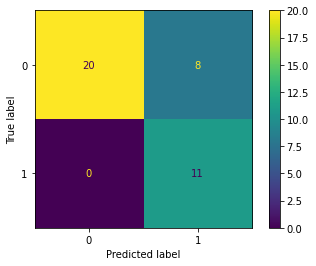

In [ ]:
print_model_experiment_results("SVM", prognosis_y_test_original, y_pred_svm_prognosis_downsampling)

# Logistic Regression

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
param_grid = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'penalty': ['none', 'l1', 'l2', 'elasticnet'],
               'C': [50, 10, 1.0, 0.1, 0.01]}
base_estimator = LogisticRegression()
cv = kfold
lr_result_prognosis_downsampling = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_downsampling, prognosis_y_train_downsampling)
y_pred_lr_prognosis_downsampling = lr_result_prognosis_downsampling.predict(prognosis_X_test_original)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is no

In [ ]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (lr_result_prognosis_downsampling.best_score_, lr_result_prognosis_downsampling.best_params_))
means = lr_result_prognosis_downsampling.cv_results_['mean_test_score']
stds = lr_result_prognosis_downsampling.cv_results_['std_test_score']
params = lr_result_prognosis_downsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.700000 using Best Hyperparameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
0.600000 (0.200000) with: {'C': 50, 'penalty': 'none', 'solver': 'newton-cg'}
0.600000 (0.200000) with: {'C': 50, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'none', 'solver': 'liblinear'}
0.600000 (0.200000) with: {'C': 50, 'penalty': 'none', 'solver': 'sag'}
0.650000 (0.200000) with: {'C': 50, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'lbfgs'}
0.550000 (0.187083) with: {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'sag'}
0.600000 (0.200000) with: {'C': 50, 'penalty': 'l1', 'solver': 'saga'}
0.600000 (0.200000) with: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.600000 (0.200000) with: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.600000 (0.20000

		HASIl UJI COBA LOGISTIC REGRESSION
	Akurasi Score:  0.6923076923076923
	Macro Recall Score:  0.7581168831168831
	Macro Precision Score:  0.7103174603174602
	Macro F1-score Score:  0.6820652173913043
	Macro F2-score Score:  0.7115384615384617
	Macro F0.5-score Score:  0.6881578947368422


              precision    recall  f1-score   support

           0       0.94      0.61      0.74        28
           1       0.48      0.91      0.62        11

    accuracy                           0.69        39
   macro avg       0.71      0.76      0.68        39
weighted avg       0.81      0.69      0.71        39



<Figure size 1008x576 with 0 Axes>

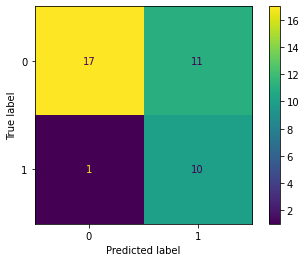

In [ ]:
print_model_experiment_results("Logistic Regression", prognosis_y_test_original, y_pred_lr_prognosis_downsampling)

# Naive Bayes

In [ ]:
param_grid = {"alpha": [50, 10, 1.0, 0.1, 0.01],
              "fit_prior": (True, False),
              'class_prior': [None, [.1,.9],[.2, .8]],
            }
base_estimator = MultinomialNB()
cv = kfold
nb_result_prognosis_downsampling = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_downsampling, prognosis_y_train_downsampling)
y_pred_nb_prognosis_downsampling = nb_result_prognosis_downsampling.predict(prognosis_X_test_original)

In [ ]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (nb_result_prognosis_downsampling.best_score_, nb_result_prognosis_downsampling.best_params_))
means = nb_result_prognosis_downsampling.cv_results_['mean_test_score']
stds = nb_result_prognosis_downsampling.cv_results_['std_test_score']
params = nb_result_prognosis_downsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.575000 using Best Hyperparameters: {'alpha': 1.0, 'class_prior': None, 'fit_prior': False}
0.750000 (0.158114) with: {'alpha': 50, 'class_prior': None, 'fit_prior': True}
0.750000 (0.273861) with: {'alpha': 50, 'class_prior': None, 'fit_prior': False}
0.350000 (0.254951) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.350000 (0.254951) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.350000 (0.254951) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': True}
0.350000 (0.254951) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': False}
0.750000 (0.158114) with: {'alpha': 10, 'class_prior': None, 'fit_prior': True}
0.750000 (0.273861) with: {'alpha': 10, 'class_prior': None, 'fit_prior': False}
0.350000 (0.254951) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.350000 (0.254951) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.350000 (0.254951) with: {'alpha': 10, 'class_prior':

		HASIl UJI COBA NAIVE BAYES
	Akurasi Score:  0.6666666666666666
	Macro Recall Score:  0.7126623376623377
	Macro Precision Score:  0.6723684210526316
	Macro F1-score Score:  0.6520247083047357
	Macro F2-score Score:  0.6759899809160306
	Macro F0.5-score Score:  0.6559065934065934


              precision    recall  f1-score   support

           0       0.89      0.61      0.72        28
           1       0.45      0.82      0.58        11

    accuracy                           0.67        39
   macro avg       0.67      0.71      0.65        39
weighted avg       0.77      0.67      0.68        39



<Figure size 1008x576 with 0 Axes>

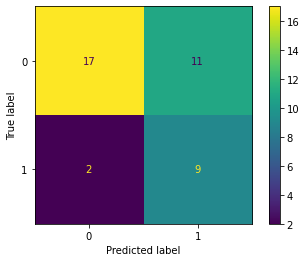

In [ ]:
print_model_experiment_results("Naive Bayes", prognosis_y_test_original, y_pred_nb_prognosis_downsampling)

# Decision Tree

In [ ]:
param_grid = {'criterion': ('gini', 'entropy', 'log_loss'),
               'ccp_alpha': [50, 10, 1.0, 0.1, 0.01],
              'splitter': ('best', 'random')
              }
base_estimator = DecisionTreeClassifier()
cv = kfold
dt_result_prognosis_downsampling = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_downsampling, prognosis_y_train_downsampling)
y_pred_dt_prognosis_downsampling = dt_result_prognosis_downsampling.predict(prognosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message, FitFailedW

In [ ]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (dt_result_prognosis_downsampling.best_score_, dt_result_prognosis_downsampling.best_params_))
means = dt_result_prognosis_downsampling.cv_results_['mean_test_score']
stds = dt_result_prognosis_downsampling.cv_results_['std_test_score']
params = dt_result_prognosis_downsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.600000 using Best Hyperparameters: {'ccp_alpha': 0.01, 'criterion': 'gini', 'splitter': 'random'}
0.450000 (0.187083) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'best'}
0.450000 (0.187083) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'random'}
0.450000 (0.187083) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'best'}
0.450000 (0.187083) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'random'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'best'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'random'}
0.450000 (0.187083) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'best'}
0.450000 (0.187083) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'random'}
0.450000 (0.187083) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'best'}
0.450000 (0.187083) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'random'}
0.000000

		HASIl UJI COBA DECISION TREE
	Akurasi Score:  0.5897435897435898
	Macro Recall Score:  0.6314935064935066
	Macro Precision Score:  0.6071428571428572
	Macro F1-score Score:  0.5760869565217391
	Macro F2-score Score:  0.5961538461538461
	Macro F0.5-score Score:  0.5855263157894737


              precision    recall  f1-score   support

           0       0.83      0.54      0.65        28
           1       0.38      0.73      0.50        11

    accuracy                           0.59        39
   macro avg       0.61      0.63      0.58        39
weighted avg       0.71      0.59      0.61        39



<Figure size 1008x576 with 0 Axes>

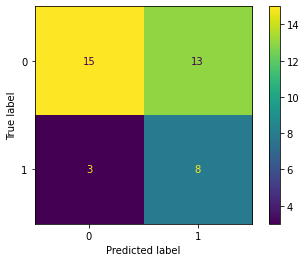

In [ ]:
print_model_experiment_results("Decision Tree", prognosis_y_test_original, y_pred_dt_prognosis_downsampling)

# ANN

In [ ]:
ann_params = {
              'batch_size': [10, 20, 40, 60, 80, 100],
              #'epochs': [10, 50, 100],
              'activation': ('identity', 'softmax', 'logistic', 'tanh', 'relu'),
              'solver':('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'alpha': [0.1, 0.01, 0.0001],
              }
# create model
base_estimator = MLPClassifier()
cv = kfold
ann_result_prognosis_downsampling = HalvingGridSearchCV(base_estimator, ann_params, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_downsampling, diagnosis_y_train_downsampling)
y_pred_ann_prognosis_downsampling = ann_result_prognosis_downsampling.predict(diagnosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 440, in _fit
    self._fit_lbfgs(
  File "/usr/local

In [ ]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (ann_result_prognosis_downsampling.best_score_, ann_result_prognosis_downsampling.best_params_))
means = ann_result_prognosis_downsampling.cv_results_['mean_test_score']
stds = ann_result_prognosis_downsampling.cv_results_['std_test_score']
params = ann_result_prognosis_downsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.940129 using Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 40, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.616667 (0.331662) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'sgd'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'adam'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.400000 (0.275882) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.950000 (0.100000) with: {'activation': 'ident

		HASIl UJI COBA ANN
	Akurasi Score:  0.956140350877193
	Macro Recall Score:  0.9556174254831313
	Macro Precision Score:  0.9516233766233766
	Macro F1-score Score:  0.9535338713621913
	Macro F2-score Score:  0.954763025737602
	Macro F0.5-score Score:  0.9523670140108496


              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



<Figure size 1008x576 with 0 Axes>

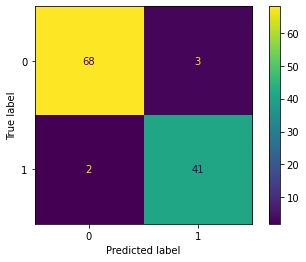

In [ ]:
print_model_experiment_results("ANN", diagnosis_y_test_original, y_pred_ann_prognosis_downsampling)

# Create Stacking ML Ensemble

In [ ]:
gridsearchcv__ensemble_classifiers_prognosis_downsampling = EnsembleStacking(
    prognosis_X_train_downsampling,
    prognosis_y_train_downsampling,
    prognosis_X_test_original,
    prognosis_y_test_original,
    kfold
).train_ensemble()

In [ ]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results = list()
for model in gridsearchcv__ensemble_classifiers_prognosis_downsampling.keys():
    ensemble_classifiers_results.append(pd.DataFrame(gridsearchcv__ensemble_classifiers_prognosis_downsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results = pd.concat(ensemble_classifiers_results, axis=0)

In [ ]:
ensemble_classifiers_results

,train,training,validation,testing
model-2,SVC(),0.910714,0.571429,0.692308
model-3,SVC(),0.892857,0.5,0.692308
model-1,SVC(),0.892857,0.5,0.641026
model-4,SVC(),0.875,0.5,0.641026
model-5,SVC(),0.892857,0.642857,0.512821
model-2,LogisticRegression(solver='newton-cg'),0.732143,0.571429,0.717949
model-3,LogisticRegression(solver='newton-cg'),0.803571,0.5,0.666667
model-4,LogisticRegression(solver='newton-cg'),0.767857,0.5,0.641026
model-1,LogisticRegression(solver='newton-cg'),0.75,0.571429,0.615385
model-5,LogisticRegression(solver='newton-cg'),0.767857,0.714286,0.564103


# Create new input Training from the stacking ensemble ML

In [ ]:
gridsearchcv_algorithm_new_input_training_features_prognosis_downsampling = create_new_input_features(
    gridsearchcv__ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_train_original,
    prognosis_y_train_original
)


			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [ ]:
gridsearchcv_algorithm_new_input_training_features_prognosis_downsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,1,1,1,1,0
1,1,1,1,1,1
2,1,1,1,1,0
3,1,1,1,1,1
4,0,1,1,0,0


# Feed New Input Features into ANN Model

In [ ]:
# split X and y from new_input_features before feeding to ANN
new_X_train = gridsearchcv_algorithm_new_input_training_features_prognosis_downsampling.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = gridsearchcv_algorithm_new_input_training_features_prognosis_downsampling[
    'ground_truth']
ann_params = {
              'batch_size': [10, 20, 40, 60, 80, 100],
              #'epochs': [10, 50, 100],
              'activation': ('identity', 'softmax', 'logistic', 'tanh', 'relu'),
              'solver':('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'alpha': [0.1, 0.01, 0.0001],
              }

# create model
base_estimator = MLPClassifier()
cv = kfold
ann_result_prognosis_downsampling_gs = HalvingGridSearchCV(base_estimator, ann_params, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(new_X_train, new_y_train)
y_pred_ann_prognois_downsampling = ann_result_prognosis_downsampling_gs.predict(new_X_train)



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 440, in _fit
    self._fit_lbfgs(
  File "/usr/local

In [ ]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (ann_result_prognosis_downsampling.best_score_, ann_result_prognosis_downsampling.best_params_))
means = ann_result_prognosis_downsampling.cv_results_['mean_test_score']
stds = ann_result_prognosis_downsampling.cv_results_['std_test_score']
params = ann_result_prognosis_downsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.940129 using Best Hyperparameters: {'activation': 'tanh', 'alpha': 0.0001, 'batch_size': 40, 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.616667 (0.331662) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'sgd'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'adam'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.400000 (0.275882) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.950000 (0.100000) with: {'activation': 'ident

		HASIl UJI COBA ANN
	Akurasi Score:  0.8506493506493507
	Macro Recall Score:  0.8529411764705882
	Macro Precision Score:  0.7889150943396226
	Macro F1-score Score:  0.8103346720214191
	Macro F2-score Score:  0.8327849674636251
	Macro F0.5-score Score:  0.7954056838740559


              precision    recall  f1-score   support

           0       0.95      0.85      0.90       119
           1       0.62      0.86      0.72        35

    accuracy                           0.85       154
   macro avg       0.79      0.85      0.81       154
weighted avg       0.88      0.85      0.86       154



<Figure size 1008x576 with 0 Axes>

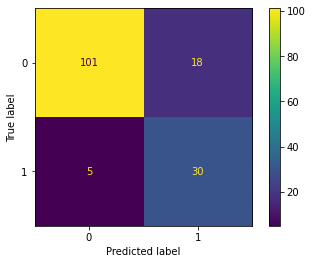

In [ ]:
print_model_experiment_results("ANN", new_y_train, y_pred_ann_prognois_downsampling)

# **Testing Result**

## GS combine Ensemble stacking ML - ANN

### Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [ ]:
gridsearchcv_new_input_testing_features_prognosis_downsampling = create_new_input_features(
    gridsearchcv__ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


### Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING PROGNOSIS BREAST CANCER (DOWNSAMPLING) + GRIDSEARCHCV 
	Akurasi Score:  0.7435897435897436
	Macro Recall Score:  0.7662337662337663
	Macro Precision Score:  0.7192513368983957
	Macro F1-score Score:  0.7214285714285714
	Macro F2-score Score:  0.7419867873746024
	Macro F0.5-score Score:  0.7158446093408991


              precision    recall  f1-score   support

           0       0.91      0.71      0.80        28
           1       0.53      0.82      0.64        11

    accuracy                           0.74        39
   macro avg       0.72      0.77      0.72        39
weighted avg       0.80      0.74      0.76        39



<Figure size 1008x576 with 0 Axes>

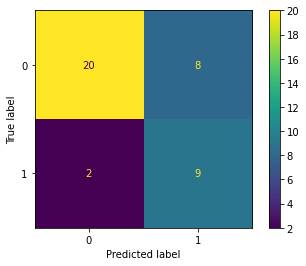

In [ ]:
# split X and y from new_input_features before feeding to ANN
new_X_test = gridsearchcv_new_input_testing_features_prognosis_downsampling.drop(['ground_truth'],axis=1)
new_y_test = gridsearchcv_new_input_testing_features_prognosis_downsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_prognosis_downsampling_gs = ann_result_prognosis_downsampling_gs.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Prognosis Breast Cancer (DownSampling) + GridSearchCV ', new_y_test, predicted_test_prognosis_downsampling_gs)

# Ensemble stacking ML - ANN (without GS)

## Create New Input Features from stacking ensemble ML before ANN process for preparing testing data new input features

In [ ]:
new_input_testing_features_prognosis_downsampling = create_new_input_features(
    ensemble_classifiers_prognosis_downsampling, 
    prognosis_X_test_original,
    prognosis_y_test_original
)

			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


## Feed new testing input features into ANN pre-trained model

		HASIl UJI COBA HASIL PENGUJIAN DATA TESTING DIAGNOSIS BREAST CANCER (DOWNSAMPLING)
	Akurasi Score:  0.6923076923076923
	Macro Recall Score:  0.702922077922078
	Macro Precision Score:  0.6671122994652406
	Macro F1-score Score:  0.6657142857142857
	Macro F2-score Score:  0.682346464399315
	Macro F0.5-score Score:  0.662647315582715


              precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.47      0.73      0.57        11

    accuracy                           0.69        39
   macro avg       0.67      0.70      0.67        39
weighted avg       0.75      0.69      0.71        39



<Figure size 1008x576 with 0 Axes>

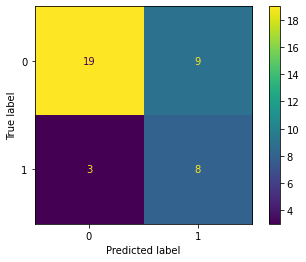

In [ ]:
# split X and y from new_input_features before feeding to ANN
new_X_test = new_input_testing_features_prognosis_downsampling.drop(['ground_truth'],axis=1)
new_y_test = new_input_testing_features_prognosis_downsampling['ground_truth']

# predict new X test using pre-trained ANN before
predicted_test_downsampling = ann_model_prognosis_downsampling.predict(new_X_test)

# print testing results
print_model_experiment_results('Hasil Pengujian Data Testing Diagnosis Breast Cancer (Downsampling)', new_y_test, predicted_test_downsampling)
